# Modelo de expected goals (xG)

## Índice

- Importando bibliotecas necessárias
- Importando o dataset
 - Separando os grupos de treino e teste
- Visualizando os dados
 - Finalizações por posição no campo
 - Resultado das finalizações
 - Gols por tipo de finalização
 - Gols por situação de ataque
- Pre-processamento do dataset
 - Atributos de ângulo e distância
 - OneHotEncoder
 - Padronização dos dados
 - Correlação entre os atributos
- Modelos de aprendizado de máquina
 - Random Search
 - Regressão Logística
 - XGBoost
- Avaliação dos resultados

### Importando bibliotecas necessárias

In [1]:
import pandas as pd

from mplsoccer import Pitch, VerticalPitch

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, r2_score, ConfusionMatrixDisplay, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from scipy.stats import uniform

from xgboost import XGBClassifier
import xgboost as xgb

### Importando os dados

In [2]:
df = pd.read_csv('FullShotsData.csv')
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Trézéguet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


In [3]:
def plot_shot_map(df):
    df_sample = df.sample(n=250)

    df_goals = df_sample[df_sample.result == 'Goal'].copy()

    df_nongoals = df_sample[df_sample.result != 'Goal'].copy()

    pitch = VerticalPitch(pitch_type='metricasports', pitch_length=105, pitch_width=68, half=True, pitch_color='#1a1c2c')

    fig, ax = pitch.draw(figsize=(9, 9))

    sc2 = pitch.scatter(df_nongoals['X'], df_nongoals['Y'],
                        c='#ea323c',
                        marker='o',
                        ax=ax,
                        label="Não Gol")

    sc1 = pitch.scatter(df_goals['X'], df_goals['Y'],
                        c='#38b764',
                        marker='o',
                        ax=ax,
                        label="Gol")

    plt.savefig('imgs/shotmap.png', dpi=300)

    plt.show()

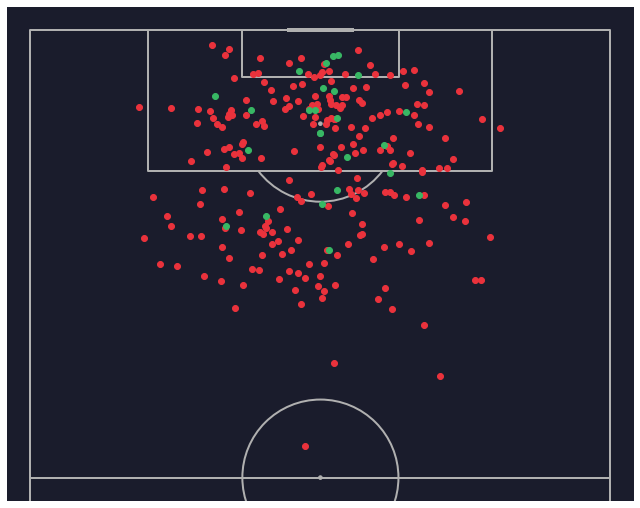

In [4]:
plot_shot_map(df)

### Separando grupos de treino e teste
Os grupos de treino e teste são determinados pela data, sendo aproximadamente 20% teste e 80% treino

In [5]:
training_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

### Visualizando os dados

In [6]:
def plot_shot_result(df):
    result_counts = df['result'].value_counts()

    plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)

    plt.title('Relação entre chutes e gols')

    plt.axis('equal')

    plt.savefig('imgs/shotresult.png', format='png', dpi=300)

    plt.show()
    
def plot_shot_type(df):
    
    total_shots = df.groupby('shotType')['result'].count()

    goals = df[df['result'] == 'Goal'].groupby('shotType')['result'].count()

    goals_percent = (goals / total_shots) * 100

    plt.figure(figsize=(8, 6))
    plt.bar(goals.index, goals_percent, color='lightblue', edgecolor='black')

    plt.title('Percentual de Gols por Tipo de Finalização', fontsize=16)
    plt.xlabel('Tipo de Finalização', fontsize=12)
    plt.ylabel('Percentual de Gols (%)', fontsize=12)

    for i, value in enumerate(goals_percent):
        plt.text(i, value + 0.1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.savefig('imgs/shotType.png', dpi=300)

    plt.show()

def plot_shot_situation(df):
    
    total_shots = df.groupby('situation')['result'].count()

    goals = df[df['result'] == 'Goal'].groupby('situation')['result'].count()

    goals_percent = (goals / total_shots) * 100

    plt.figure(figsize=(8, 6))
    plt.bar(goals.index, goals_percent, color='lightblue', edgecolor='black')

    plt.title('Percentual de Gols por Situação de Ataque', fontsize=16)
    plt.xlabel('Situação de Ataque', fontsize=12)
    plt.ylabel('Percentual de Gols (%)', fontsize=12)

    for i, value in enumerate(goals_percent):
        plt.text(i, value + 0.1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.savefig('imgs/atackSituation.png', dpi=300)

    plt.show()

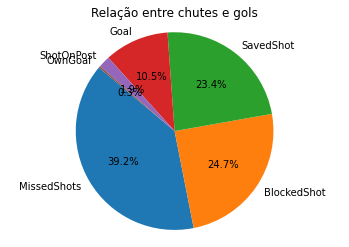

In [7]:
 plot_shot_result(training_set)

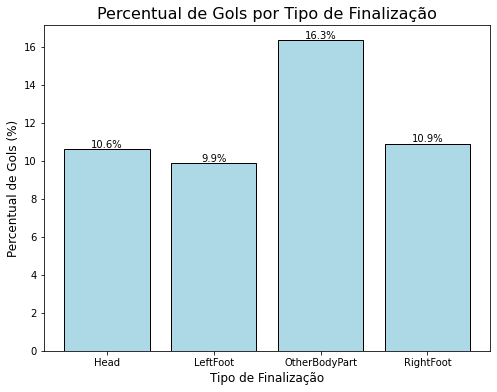

In [8]:
plot_shot_type(training_set)

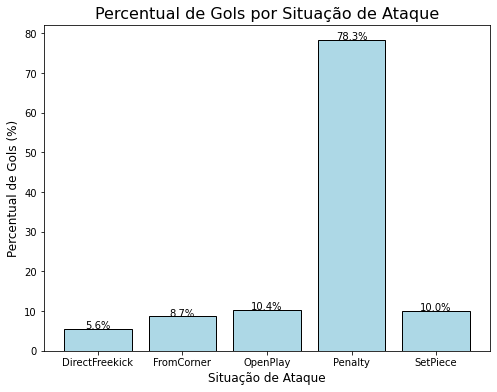

In [9]:
plot_shot_situation(test_set)

### Pre-processamento dos dados

In [10]:
def get_angle(A, B, C):

    AB = np.array([B[0] - A[0], B[1] - A[1]])
    AC = np.array([C[0] - A[0], C[1] - A[1]])

    produto_escalar = np.dot(AB, AC)
    norma_AB = np.linalg.norm(AB)
    norma_AC = np.linalg.norm(AC)

    cos_theta = produto_escalar / (norma_AB * norma_AC)
    angulo_radianos = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    angulo_graus = np.degrees(angulo_radianos)
    return angulo_graus

In [11]:
def get_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [12]:
def oneHotEncoder(df: pd.DataFrame):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')
    ohetransform = ohe.fit_transform(df[['situation', 'shotType', 'lastAction']])
    df = pd.concat([df, ohetransform], axis=1)
    df = df.drop(['situation', 'shotType', 'lastAction'], axis=1)
    
    return df

In [13]:
def standardization(df: pd.DataFrame):
    df = df.reset_index(drop=True)
    
    standardScale = StandardScaler()

    variaveisContinuas = df[['angulo', 'distancia']]
    variaveisContinuas = standardScale.fit_transform(variaveisContinuas)
    variaveisContinuas = pd.DataFrame(variaveisContinuas, columns=['angulo', 'distancia'])
    
    df = df.drop(['angulo', 'distancia'], axis=1)
    df = pd.concat([df, variaveisContinuas], axis=1)
    
    return df

In [14]:
def preProcessing(df: pd.DataFrame):
    # posição do gol e traves de acordo com o metricasports
    post_1 = [1, 0.5538]
    post_2 = [1, 0.4462]
    goal_center = [1,0.5]

    # adiciona o ângulo entre o finalizador e o gol
    df.loc[:, 'angulo'] = df.apply(lambda r: get_angle((r['X'], r['Y']), post_1, post_2), axis=1)
    df.loc[:, 'distancia'] = df.apply(lambda r: get_distance((r['X'], r['Y']), goal_center), axis=1)
    # remove os atributos não utilizados
    df = df[['id', 'result', 'situation', 'shotType', 'lastAction', 'angulo', 'distancia']]
    # retira os gols contra
    df = df[df['result'] != 'OwnGoal']
    # substitui as variáveis categóricas
    df = oneHotEncoder(df)
    # substitui resultados em gol e não gol
    df['result'] = (df['result'] == 'Goal').astype(int)
    # padroniza
    df = standardization(df)
    
    return df

In [15]:
proc_train = preProcessing(training_set)
proc_test = preProcessing(test_set)

### Correlação dos atributos

In [16]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    plt.title('Matriz de Correlação')
    plt.show()

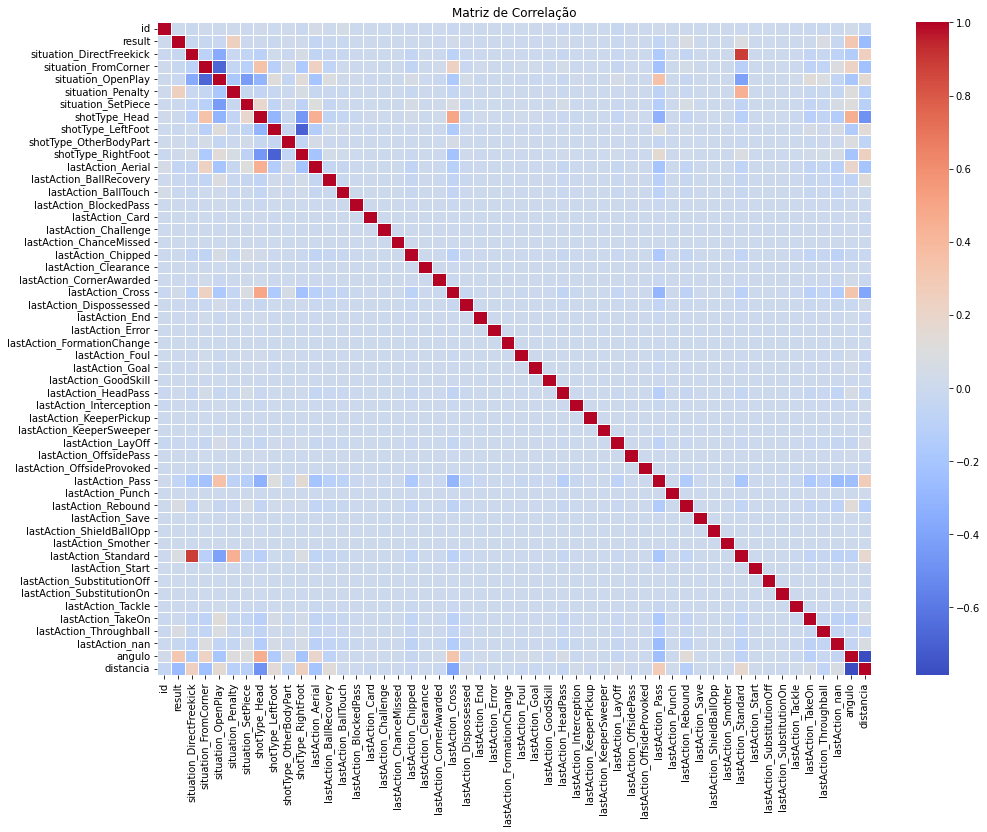

In [17]:
plot_correlation_matrix(proc_train)

### Random Search
Minimizando a perda logarítimica

In [18]:
X_train = proc_train.drop(['id', 'result'], axis=1)
X_test = proc_test.drop(['id', 'result'], axis=1)
y_train = proc_train['result']
y_test = proc_test['result']

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [19]:
def random_search_lr(X_train, y_train):
    lr = LogisticRegression()

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['liblinear', 'saga'],
        'l1_ratio': [0.1, 0.5, 0.9]
    }

    random_search = RandomizedSearchCV(lr, param_distributions=param_grid, n_iter=20, scoring='neg_log_loss', n_jobs=-1, cv=5, random_state=0)
    random_search.fit(X_train, y_train)

    return random_search.best_params_, random_search.best_estimator_

def random_search_rf(X_train, y_train):
    rf = RandomForestClassifier()

    param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    }

    random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, scoring='neg_log_loss',n_jobs=-1, cv=5, random_state=0)
    random_search.fit(X_train, y_train)

    return random_search.best_params_, random_search.best_estimator_

def random_search_xgboost(X_train, y_train):
    xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    param_grid = {
        'n_estimators': [100, 200, 300],        # número de árvores
        'learning_rate': [0.01, 0.05, 0.1, 0.2],# taxa de aprendizado
        'eta': [0.05, 0.1, 0.3, 0.5],
        'max_depth': [3, 4, 5],                 # limite de profundidade
        'subsample': [0.6, 0.8, 1.0],           # porcentagem de amostras por árvore
        'colsample_bytree': [0.6, 0.8, 1.0],    # porcentagem de features por árvore
        'gamma': [0, 1, 5],                     # penalização para splits adicionais
        'min_child_weight': [1, 3, 5],         # mínimo de soma de pesos por folha
        'reg_alpha': [0, 0.1, 1],              # regularização L1 (lasso)
        'reg_lambda': [1, 5, 10]                # regularização L2 (ridge)
    }
    random_search = RandomizedSearchCV(xgboost, param_distributions=param_grid, n_iter=20, scoring='neg_log_loss', n_jobs=-1, cv=5, random_state=0)
    random_search.fit(X_train, y_train)

    return random_search.best_params_, random_search.best_estimator_

In [20]:
lr_best_params, lr_model = random_search_lr(X_train, y_train)

D:\Pedro\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Pedro\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Pedro\Anaconda\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\Pedro\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Pedro\Anaconda\

In [21]:
rf_best_params, rf_model = random_search_rf(X_train, y_train)

In [22]:
xgboost_best_params, xgb_model = random_search_xgboost(X_train, y_train)

## Resultados

In [23]:
def get_xG(model, X_test):
    return model.predict_proba(X_test)

def print_log_loss(models, X_test, y_test):
    for model in models:
        y_pred = get_xG(model, X_test)
        y_log_loss = log_loss(y_test, y_pred, normalize=True, sample_weight=None, labels=None)
        print(f'For {model}, log loss = {y_log_loss}')

In [24]:
models = [lr_model, rf_model, xgb_model]

print_log_loss(models, X_test, y_test)

For LogisticRegression(C=10, l1_ratio=0.1, penalty='l1', solver='saga'), log loss = 0.2678095139868664
For RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200), log loss = 0.27156563481565776
For XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ..

In [25]:
preprocessed_df = preProcessing(df).drop(['id', 'result'], axis=1)

In [26]:
lr_xg = get_xG(lr_model, preprocessed_df)
rf_xg = get_xG(rf_model, preprocessed_df)
xgb_xg = get_xG(xgb_model, preprocessed_df)

In [27]:
df_with_xg = df[df['result'] != 'OwnGoal'].copy()

In [28]:
df_with_xg.loc[:, 'Xg - Logistic Regression'] = lr_xg[:, 1]
df_with_xg.loc[:, 'Xg - Random Forest'] = rf_xg[:, 1]
df_with_xg.loc[:, 'Xg - XGBoost'] = xgb_xg[:, 1]
df_with_xg.rename(columns={'xG': 'Xg - Metrica Sports'}, inplace=True)

In [29]:
def plot_match_xG(df, match_id, xg_columns=['metricasports_xg', 'xgb_xg']):
    df_match = df[df['match_id'] == match_id]
    models = xg_columns

    fig, axes = plt.subplots(1, len(models), figsize=(9 * len(models), 9))

    if len(models) == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        home_team = df_match[df_match['h_a'] == 'h']
        away_team = df_match[df_match['h_a'] == 'a']

        home_goals = home_team[home_team['result'] == 'Goal']
        home_non_goals = home_team[home_team['result'] != 'Goal']

        away_goals = away_team[away_team['result'] == 'Goal']
        away_non_goals = away_team[away_team['result'] != 'Goal']

        pitch = Pitch(pitch_type='metricasports',
                      pitch_length=105, pitch_width=68,
                      pitch_color='#1a1c2c')

        pitch.draw(ax=ax)

        pitch.scatter(home_non_goals['X'], home_non_goals['Y'],
                      c='#ea323c', marker='o',
                      s=home_non_goals[model] * 1000,
                      alpha=0.7,
                      ax=ax, label="Não Gol")

        pitch.scatter(1 - away_non_goals['X'], 1 - away_non_goals['Y'],
                      c='#ea323c', marker='o',
                      s=away_non_goals[model] * 1000,
                      alpha=0.7,
                      ax=ax)
        
        pitch.scatter(home_goals['X'], home_goals['Y'],
                      c='#38b764', marker='o',
                      s=home_goals[model] * 1000,
                      alpha=0.7,
                      ax=ax, label="Gol")


        pitch.scatter(1 - away_goals['X'], 1 - away_goals['Y'],
                      c='#38b764', marker='o',
                      s=away_goals[model] * 1000,
                      alpha=0.7,
                      ax=ax)

        ax.set_title(
            f"{home_team['h_team'].iloc[0]} {df_match['h_goals'].iloc[0]} vs {df_match['a_goals'].iloc[0]} {away_team['a_team'].iloc[0]}\n{home_team['date'].iloc[0]}",
            fontsize=18
        )
        
        home_match_xg = home_goals[model].sum() + home_non_goals[model].sum()
        away_match_xg = away_goals[model].sum() + away_non_goals[model].sum()
                
        ax.text(
            0.5, -0.1,
            f"{home_team['h_team'].iloc[0]} {home_match_xg:.2f} vs {away_match_xg:.2f} {away_team['a_team'].iloc[0]}\n{model}",
            ha='center', va='center', transform=ax.transAxes, fontsize=14
        )
        
    plt.savefig(f"imgs/{home_team['h_team'].iloc[0]} {home_match_xg:.2f} vs {away_match_xg:.2f} {away_team['a_team'].iloc[0]} {model}.jpg")
    plt.show()

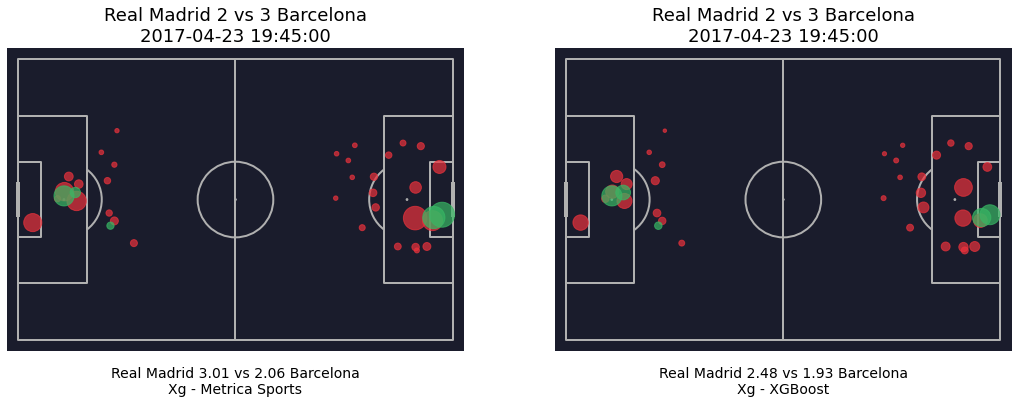

In [30]:
match1_id = 4047 # Real madrid x Barcelona 2017

plot_match_xG(df_with_xg, match1_id, xg_columns=['Xg - Metrica Sports', 'Xg - XGBoost'])

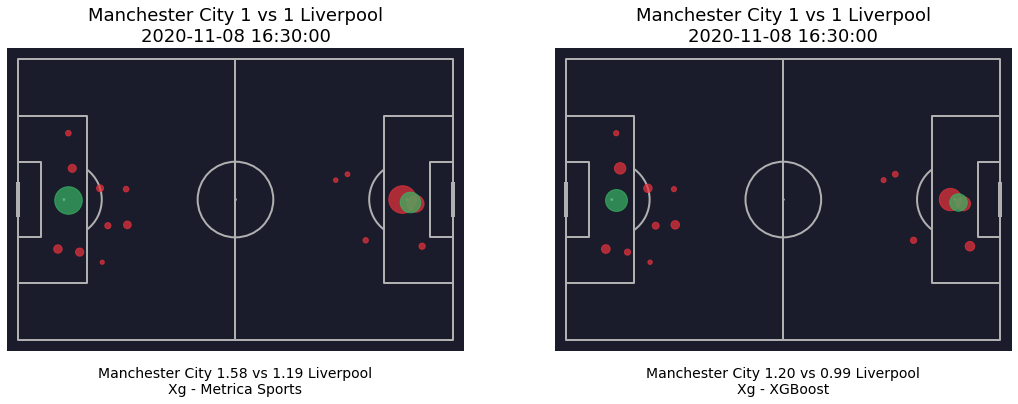

In [31]:
match2_id = 14511 # Man City x Liverpool

plot_match_xG(df_with_xg, match2_id, xg_columns=['Xg - Metrica Sports', 'Xg - XGBoost'])

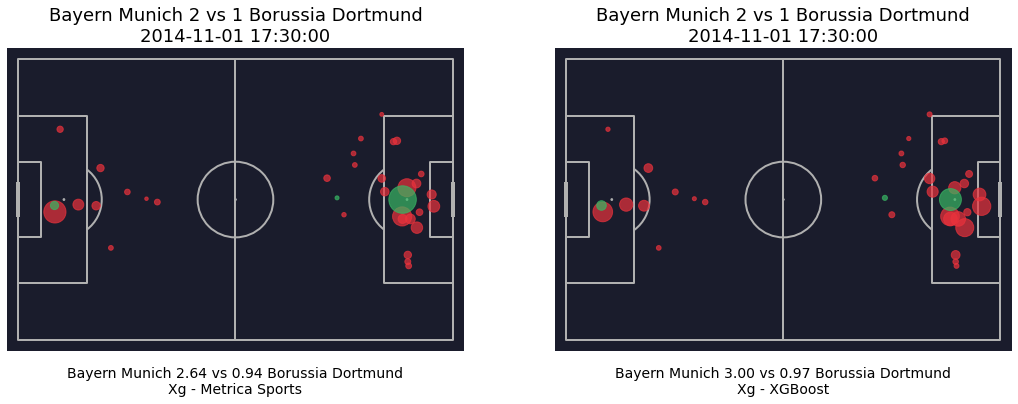

In [32]:
match3_id = 5352 # Bayern Munich vs Borussia Dortmund

plot_match_xG(df_with_xg, match3_id, xg_columns=['Xg - Metrica Sports', 'Xg - XGBoost'])

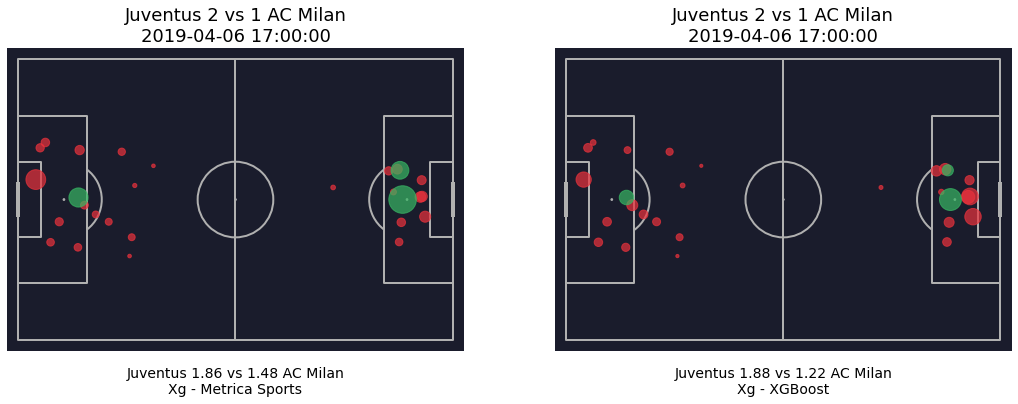

In [33]:
match4_id = 9886 # Juventus x Milan

plot_match_xG(df_with_xg, match4_id, xg_columns=['Xg - Metrica Sports', 'Xg - XGBoost'])

In [34]:
 def plot_correlation_models(df):
    corr = df[['Xg - Logistic Regression', 'Xg - Random Forest','Xg - XGBoost','Xg - Metrica Sports']].corr()

    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.savefig('imgs/models correlation.jpg')
    plt.show()

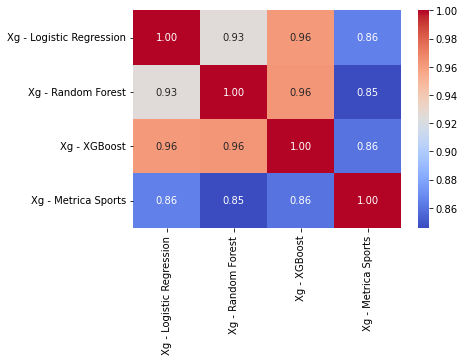

In [35]:
plot_correlation_models(df_with_xg)

In [36]:
ms_log_loss = log_loss(df_with_xg['result'] == 'Goal', df_with_xg['Xg - Metrica Sports'], normalize=True, sample_weight=None, labels=None)

print(f'For Metrica Sports model, log loss = {ms_log_loss}')

For Metrica Sports model, log loss = 0.25132701711976163


In [37]:
df_with_xg

,id,minute,result,X,Y,Xg - Metrica Sports,player,h_a,player_id,situation,...,h_goals,a_goals,date,player_assisted,lastAction,angulo,distancia,Xg - Logistic Regression,Xg - Random Forest,Xg - XGBoost
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,...,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial,30.242404,0.160562,0.023282,0.007390,0.011647
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,...,1,0,2020-09-21 17:00:00,Trézéguet,Cross,37.855697,0.140656,0.067919,0.024991,0.035793
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,...,1,0,2020-09-21 17:00:00,John McGinn,Pass,17.215935,0.228484,0.050214,0.038224,0.052410
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,...,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn,20.099869,0.229316,0.072435,0.063326,0.060653
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,...,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross,86.691447,0.057000,0.229414,0.316547,0.264487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292065,28658.0,58,MissedShots,0.673,0.499,0.008183,Florian Hartherz,h,4267,SetPiece,...,0,6,2015-02-21 14:30:00,NaN,NaN,18.685723,0.327001,0.009024,0.009743,0.005930
292066,25266.0,14,MissedShots,0.762,0.744,0.014528,Idir Ouali,a,4311,OpenPlay,...,4,0,2014-09-23 19:00:00,Christian Strohdiek,TakeOn,12.737920,0.340852,0.017636,0.024131,0.012608
292067,25269.0,23,SavedShot,0.853,0.585,0.246003,Idir Ouali,a,4311,OpenPlay,...,4,0,2014-09-23 19:00:00,Moritz Stoppelkamp,Pass,31.373645,0.169806,0.121448,0.110541,0.123916
292068,31573.0,73,MissedShots,0.716,0.705,0.020342,Idir Ouali,h,4311,OpenPlay,...,2,1,2015-04-11 14:30:00,Mario Vrancic,Pass,14.311312,0.350258,0.011528,0.021566,0.015739
